In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '6'
import sys

import re
import math

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sb

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, KBinsDiscretizer, LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, adjusted_mutual_info_score
from sklearn.metrics.pairwise import cosine_similarity

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth

import warnings
warnings.filterwarnings('ignore')

from scripts.path import return_path
PATH = return_path() + 'laptops_data/'


# READ DATA

In [2]:
laptops_train = pd.read_csv(f'{PATH}laptops_train.csv').rename(columns={' Storage': 'Storage'})
display(laptops_train.head(5))

laptops_test = pd.read_csv(f'{PATH}laptops_test.csv').rename(columns={' Storage': 'Storage'})
display(laptops_test.head(5))

,Manufacturer,Model Name,Category,Screen Size,Screen,CPU,RAM,Storage,GPU,Operating System,Operating System Version,Weight,Price
0,Apple,MacBook Pro,Ultrabook,"13.3""",IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,NaN,1.37kg,11912523.48
1,Apple,Macbook Air,Ultrabook,"13.3""",1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,NaN,1.34kg,7993374.48
2,HP,250 G6,Notebook,"15.6""",Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,NaN,1.86kg,5112900.00
3,Apple,MacBook Pro,Ultrabook,"15.4""",IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,NaN,1.83kg,22563005.40
4,Apple,MacBook Pro,Ultrabook,"13.3""",IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,NaN,1.37kg,16037611.20


,Manufacturer,Model Name,Category,Screen Size,Screen,CPU,RAM,Storage,GPU,Operating System,Operating System Version,Weight,Price
0,HP,15-bs053od (i7-7500U/6GB/1TB/W10),Notebook,"15.6""",1366x768,Intel Core i7 7500U 2.7GHz,6GB,1TB HDD,Intel HD Graphics 620,Windows,10,2.04kg,5148468.0
1,Asus,Rog GL753VE-DS74,Gaming,"17.3""",Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,16GB,256GB SSD + 1TB HDD,Nvidia GeForce GTX 1050 Ti,Windows,10,2.99kg,15552108.0
2,Dell,Inspiron 7579,2 in 1 Convertible,"15.6""",IPS Panel Full HD / Touchscreen 1920x1080,Intel Core i7 7500U 2.7GHz,12GB,512GB SSD,Intel HD Graphics 620,Windows,10,2.19kg,11550708.0
3,Toshiba,Portege Z30-C-1CV,Notebook,"13.3""",Full HD 1920x1080,Intel Core i5 6200U 2.3GHz,4GB,128GB SSD,Intel HD Graphics 520,Windows,7,1.2kg,10625940.0
4,Lenovo,IdeaPad 320-15ABR,Notebook,"15.6""",Full HD 1920x1080,AMD A12-Series 9720P 3.6GHz,6GB,256GB SSD,AMD Radeon 530,Windows,10,2.2kg,4881708.0


## DROP MISSING DATA AND DUPLICATES

In [3]:
def drop_all(df):
    return df.dropna().drop_duplicates().reset_index(drop=True)

laptops_train = drop_all(laptops_train)
laptops_test = drop_all(laptops_test)

## DATA ANALYSIS

In [4]:
# Displays all columns in the data
display(laptops_train.info())
display(laptops_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 841 entries, 0 to 840
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Manufacturer              841 non-null    object 
 1   Model Name                841 non-null    object 
 2   Category                  841 non-null    object 
 3   Screen Size               841 non-null    object 
 4   Screen                    841 non-null    object 
 5   CPU                       841 non-null    object 
 6   RAM                       841 non-null    object 
 7   Storage                   841 non-null    object 
 8   GPU                       841 non-null    object 
 9   Operating System          841 non-null    object 
 10  Operating System Version  841 non-null    object 
 11  Weight                    841 non-null    object 
 12  Price                     841 non-null    float64
dtypes: float64(1), object(12)
memory usage: 85.5+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 267 entries, 0 to 266
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Manufacturer              267 non-null    object 
 1   Model Name                267 non-null    object 
 2   Category                  267 non-null    object 
 3   Screen Size               267 non-null    object 
 4   Screen                    267 non-null    object 
 5   CPU                       267 non-null    object 
 6   RAM                       267 non-null    object 
 7   Storage                   267 non-null    object 
 8   GPU                       267 non-null    object 
 9   Operating System          267 non-null    object 
 10  Operating System Version  267 non-null    object 
 11  Weight                    267 non-null    object 
 12  Price                     267 non-null    float64
dtypes: float64(1), object(12)
memory usage: 27.2+ KB


None

In [5]:
# Shows the unique items in the columns and their frequencies
for traincol, testcol in zip(laptops_train.columns, laptops_test.columns):
    print(traincol)
    trainfreq = np.unique(laptops_train[traincol], return_counts=True)
    traintext = repr([tuple([x, y]) for x, y in zip(trainfreq[0][:20], trainfreq[1][:20])])
    print('Train\n', ''.join([traintext[i:i+120] + '\n' for i in range(0, len(traintext), 120)]), sep='')

    testfreq = np.unique(laptops_test[traincol], return_counts=True)
    testtext = repr([tuple([x, y]) for x, y in zip(testfreq[0][:20], testfreq[1][:20])])
    print('Test\n', ''.join([testtext[i:i+120] + '\n' for i in range(0, len(testtext), 120)]), sep='')

Manufacturer
Train
[('Acer', 63), ('Apple', 4), ('Asus', 107), ('Chuwi', 3), ('Dell', 204), ('Fujitsu', 2), ('HP', 167), ('Huawei', 2), ('L
G', 3), ('Lenovo', 185), ('MSI', 34), ('Mediacom', 7), ('Microsoft', 6), ('Razer', 5), ('Samsung', 7), ('Toshiba', 39), 
('Vero', 2), ('Xiaomi', 1)]

Test
[('Acer', 13), ('Apple', 4), ('Asus', 27), ('Dell', 52), ('Fujitsu', 1), ('HP', 85), ('Lenovo', 52), ('MSI', 20), ('Raze
r', 2), ('Toshiba', 9), ('Vero', 2)]

Model Name
Train
[('110-15ACL (A6-7310/4GB/500GB/W10)', 1), ('14-am079na (N3710/8GB/2TB/W10)', 1), ('15-AY023na (N3710/8GB/2TB/W10)', 1),
 ('15-BS026nv (i5-7200U/8GB/256GB/Radeon', 1), ('15-BS028nv (i3-6006U/4GB/1TB/Radeon', 1), ('15-BS078nr (i7-7500U/8GB/1T
B/W10)', 1), ('15-BS101nv (i7-8550U/8GB/256GB/FHD/W10)', 1), ('15-BS103nv (i5-8250U/6GB/256GB/Radeon', 1), ('15-BW004nv 
(A9-9420/4GB/256GB/Radeon', 1), ('15-BW037na (A9-9420/4GB/1TB/Radeon', 1), ('15-BW091ND (A9-9420/6GB/1TB', 1), ('15-BW09
4nd (A6-9220/8GB/128GB/W10)', 1), ('15-ay047n

In [6]:
# Shows the descriptive statistics of the data
display(laptops_train.describe(include='all'))
display(laptops_test.describe(include='all'))

,Manufacturer,Model Name,Category,Screen Size,Screen,CPU,RAM,Storage,GPU,Operating System,Operating System Version,Weight,Price
count,841,841,841,841,841,841,841,841,841,841,841,841,8.410000e+02
unique,18,447,6,17,35,88,8,34,91,2,4,161,NaN
top,Dell,XPS 13,Notebook,"15.6""",Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,Windows,10,2.2kg,NaN
freq,204,22,455,406,345,131,422,287,210,837,819,72,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.060597e+07
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.380842e+06
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.706375e+06
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.948748e+06
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.167652e+06
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.377371e+07


,Manufacturer,Model Name,Category,Screen Size,Screen,CPU,RAM,Storage,GPU,Operating System,Operating System Version,Weight,Price
count,267,267,267,267,267,267,267,267,267,267,267,267,2.670000e+02
unique,11,180,6,9,20,47,8,19,52,2,3,95,NaN
top,HP,XPS 13,Notebook,"15.6""",Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 520,Windows,10,2.2kg,NaN
freq,85,7,135,130,105,35,121,91,75,263,228,15,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.094834e+07
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.941550e+06
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.742832e+06
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.664554e+06
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.022580e+07
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.417385e+07


# FREQUENT ITEMSET MINING 

### DATA PROCESSING

In [7]:
laptops = pd.concat([laptops_train, laptops_test], ignore_index=True)
display(laptops.head(3))

,Manufacturer,Model Name,Category,Screen Size,Screen,CPU,RAM,Storage,GPU,Operating System,Operating System Version,Weight,Price
0,Acer,Aspire 3,Notebook,"15.6""",1366x768,AMD A9-Series 9420 3GHz,4GB,500GB HDD,AMD Radeon R5,Windows,10,2.1kg,3556800.00
1,Apple,MacBook Pro,Ultrabook,"15.4""",IPS Panel Retina Display 2880x1800,Intel Core i7 2.2GHz,16GB,256GB Flash Storage,Intel Iris Pro Graphics,Mac OS,X,2.04kg,19028613.24
2,Asus,ZenBook UX430UN,Ultrabook,"14.0""",Full HD 1920x1080,Intel Core i7 8550U 1.8GHz,16GB,512GB SSD,Nvidia GeForce MX150,Windows,10,1.3kg,13293540.00


In [8]:
laptops_items = laptops[['Manufacturer', 'Category', 'Operating System', 'Weight']]	# Set itemsets columns
laptops_items['Weight'] = [re.sub('[^\d+\.^\d+]', '', str(item)) for item in laptops_items['Weight']]	# Remove string in weight
laptops_items['Weight'] = laptops_items['Weight'].astype('float64')	# Change datatype from string to float
display(laptops_items.head(5))

bins = np.linspace(min(laptops_items['Weight']), max(laptops_items['Weight']), 4)	# Generate equal-width bins
laptops_items['Weight'] = pd.cut(x=laptops_items['Weight'], bins=bins, labels=['Light', 'Average', 'Heavy'])	# Binning process
display(laptops_items.head(5))

,Manufacturer,Category,Operating System,Weight
0,Acer,Notebook,Windows,2.10
1,Apple,Ultrabook,Mac OS,2.04
2,Asus,Ultrabook,Windows,1.30
3,Acer,Ultrabook,Windows,1.60
4,Dell,Notebook,Windows,2.20


,Manufacturer,Category,Operating System,Weight
0,Acer,Notebook,Windows,Average
1,Apple,Ultrabook,Mac OS,Average
2,Asus,Ultrabook,Windows,Light
3,Acer,Ultrabook,Windows,Light
4,Dell,Notebook,Windows,Average


In [9]:
# Join columns
laptops_joined = pd.DataFrame()
laptops_joined['Transaction'] = [f'T{x}' for x in range(1, len(laptops_items)+1)]
laptops_joined['Itemsets'] = laptops_items[laptops_items.columns].apply(lambda x: str.join(', ', map(str, x)), axis=1)

display(laptops_joined.head(5))

,Transaction,Itemsets
0,T1,"Acer, Notebook, Windows, Average"
1,T2,"Apple, Ultrabook, Mac OS, Average"
2,T3,"Asus, Ultrabook, Windows, Light"
3,T4,"Acer, Ultrabook, Windows, Light"
4,T5,"Dell, Notebook, Windows, Average"


### ONE-HOT ENCODING

In [10]:
# One-Hot Encoding
te = TransactionEncoder()
items = laptops_items.astype('str').values.tolist()
laptops_itemsets = pd.DataFrame(te.fit_transform(items), columns=te.columns_)
laptops_itemsets = laptops_itemsets.drop(['nan'], axis=1)	# Drop nan column
display(laptops_itemsets.head(5))

,2 in 1 Convertible,Acer,Apple,Asus,Average,Chuwi,Dell,Fujitsu,Gaming,HP,...,Netbook,Notebook,Razer,Samsung,Toshiba,Ultrabook,Vero,Windows,Workstation,Xiaomi
0,False,True,False,False,True,False,False,False,False,False,...,False,True,False,False,False,False,False,True,False,False
1,False,False,True,False,True,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
2,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,True,False,True,False,False
3,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,True,False,False
4,False,False,False,False,True,False,True,False,False,False,...,False,True,False,False,False,False,False,True,False,False


### APRIORI ALGORITHM

In [11]:
# Apiori
frequent_items = apriori(laptops_itemsets, min_support=0.30, use_colnames=True)
frequent_items = frequent_items.sort_values(by='support', ascending=False).reset_index(drop=True)
display(frequent_items.head(5))

# Association rules
rules = association_rules(frequent_items, metric='confidence', min_threshold=0.30)
rules = rules.sort_values(by=['confidence'], ascending=False).reset_index(drop=True)
display(rules.head(5))

,support,itemsets
0,0.992780,(Windows)
1,0.532491,(Notebook)
2,0.532491,"(Notebook, Windows)"
3,0.498195,(Light)
4,0.491877,"(Light, Windows)"


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Notebook),(Windows),0.532491,0.992780,0.532491,1.000000,1.007273,0.003845,inf
1,(Average),(Windows),0.454874,0.992780,0.453971,0.998016,1.005274,0.002382,3.638989
2,(Light),(Windows),0.498195,0.992780,0.491877,0.987319,0.994499,-0.002721,0.569366
3,(Windows),(Notebook),0.992780,0.532491,0.532491,0.536364,1.007273,0.003845,1.008353
4,(Windows),(Light),0.992780,0.498195,0.491877,0.495455,0.994499,-0.002721,0.994569


# CLASSIFICATION

In [12]:
def show_results(predictions, y_test):
	print('Predictions\n', pd.DataFrame(predictions).value_counts(), sep='')

	accuracy = accuracy_score(predictions, y_test)
	print('\nAccuracy = ', round(accuracy*100, 4), '%', sep='')

	class_report = classification_report(predictions, y_test, digits=4)
	print('\nClassification Report\n', class_report, sep='')

	cm = confusion_matrix(y_test, predictions)
	plt.figure(figsize=(5, 4), dpi=100)

	heatmap = sb.heatmap(cm, annot=True, fmt='d')
	heatmap.set(xlabel='Predicted', ylabel='Actual', title='Confusion Matrix')

## DATA TRANSFORMATION

### LABEL ENCODING

In [13]:
le = LabelEncoder()
categorical_cols = ['Manufacturer', 'Model Name', 'Category', 'Screen', 'CPU', 'RAM', 
        'Storage', 'GPU', 'Operating System', 'Operating System Version']

# Convert categorical columns to object datatype
for col in categorical_cols:
    laptops_train[col] = le.fit_transform(laptops_train[col]).astype('int64').astype('object')
    laptops_test[col] = le.fit_transform(laptops_test[col]).astype('int64').astype('object')

display(laptops_train.head(5))
display(laptops_test.head(5))

,Manufacturer,Model Name,Category,Screen Size,Screen,CPU,RAM,Storage,GPU,Operating System,Operating System Version,Weight,Price
0,0,42,3,"15.6""",0,12,5,22,12,1,0,2.1kg,3556800.00
1,1,213,4,"15.4""",24,61,1,12,48,0,3,2.04kg,19028613.24
2,2,437,4,"14.0""",8,79,1,25,82,1,0,1.3kg,13293540.00
3,0,307,4,"14.0""",15,60,7,13,49,1,0,1.6kg,6846840.00
4,4,164,3,"15.6""",8,41,5,13,17,1,0,2.2kg,4436218.80


,Manufacturer,Model Name,Category,Screen Size,Screen,CPU,RAM,Storage,GPU,Operating System,Operating System Version,Weight,Price
0,5,5,3,"15.6""",0,39,6,3,24,1,0,2.04kg,5148468.0
1,2,126,1,"17.3""",5,41,1,8,36,1,0,2.99kg,15552108.0
2,3,78,0,"15.6""",8,39,0,15,24,1,0,2.19kg,11550708.0
3,9,101,3,"13.3""",5,25,4,0,20,1,1,1.2kg,10625940.0
4,6,61,3,"15.6""",5,1,6,7,3,1,0,2.2kg,4881708.0


### DATA DISCRETIZATION

In [14]:
float_cols = ['Screen Size', 'Weight']

# Convert float columns to float datatype
for col in float_cols:
    laptops_train[col] = [float(re.sub('[^\d+\.^\d+]', '', str(item))) for item in laptops_train[col]]
    laptops_test[col] = [float(re.sub('[^\d+\.^\d+]', '', str(item))) for item in laptops_test[col]]

display(laptops_train.head(5))
display(laptops_test.head(5))

,Manufacturer,Model Name,Category,Screen Size,Screen,CPU,RAM,Storage,GPU,Operating System,Operating System Version,Weight,Price
0,0,42,3,15.6,0,12,5,22,12,1,0,2.10,3556800.00
1,1,213,4,15.4,24,61,1,12,48,0,3,2.04,19028613.24
2,2,437,4,14.0,8,79,1,25,82,1,0,1.30,13293540.00
3,0,307,4,14.0,15,60,7,13,49,1,0,1.60,6846840.00
4,4,164,3,15.6,8,41,5,13,17,1,0,2.20,4436218.80


,Manufacturer,Model Name,Category,Screen Size,Screen,CPU,RAM,Storage,GPU,Operating System,Operating System Version,Weight,Price
0,5,5,3,15.6,0,39,6,3,24,1,0,2.04,5148468.0
1,2,126,1,17.3,5,41,1,8,36,1,0,2.99,15552108.0
2,3,78,0,15.6,8,39,0,15,24,1,0,2.19,11550708.0
3,9,101,3,13.3,5,25,4,0,20,1,1,1.20,10625940.0
4,6,61,3,15.6,5,1,6,7,3,1,0,2.20,4881708.0


In [15]:
discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
disc_cols = ['Screen Size', 'Weight', 'Price']
discretized_train, discretized_test = pd.DataFrame(), pd.DataFrame()

# Fit Transform
discretized_train[disc_cols] = discretizer.fit_transform(np.array(laptops_train[disc_cols])).astype('int64').astype('object')
discretized_test[disc_cols] = discretizer.fit_transform(np.array(laptops_test[disc_cols])).astype('int64').astype('object')

print('Discretized Train')
display(discretized_train.head(5))
print('Discretized Test')
display(discretized_test.head(5))

Discretized Train


,Screen Size,Weight,Price
0,2,2,0
1,1,2,4
2,1,0,3
3,1,1,1
4,2,3,0


Discretized Test


,Screen Size,Weight,Price
0,2,2,0
1,2,4,4
2,2,2,3
3,1,0,2
4,2,3,0


In [16]:
laptops_train[['Screen Size', 'Weight', 'Price']] = discretized_train
laptops_test[['Screen Size', 'Weight', 'Price']] = discretized_test

display(laptops_train.head(5))
display(laptops_test.head(5))

,Manufacturer,Model Name,Category,Screen Size,Screen,CPU,RAM,Storage,GPU,Operating System,Operating System Version,Weight,Price
0,0,42,3,2,0,12,5,22,12,1,0,2,0
1,1,213,4,1,24,61,1,12,48,0,3,2,4
2,2,437,4,1,8,79,1,25,82,1,0,0,3
3,0,307,4,1,15,60,7,13,49,1,0,1,1
4,4,164,3,2,8,41,5,13,17,1,0,3,0


,Manufacturer,Model Name,Category,Screen Size,Screen,CPU,RAM,Storage,GPU,Operating System,Operating System Version,Weight,Price
0,5,5,3,2,0,39,6,3,24,1,0,2,0
1,2,126,1,2,5,41,1,8,36,1,0,4,4
2,3,78,0,2,8,39,0,15,24,1,0,2,3
3,9,101,3,1,5,25,4,0,20,1,1,0,2
4,6,61,3,2,5,1,6,7,3,1,0,3,0


## SPLITTING

In [17]:
X_train = laptops_train.iloc[:, :-1].astype('int64')
X_test = laptops_test.iloc[:, :-1].astype('int64')
y_train = laptops_train.iloc[:, -1].astype('int64')
y_test = laptops_test.iloc[:, -1].astype('int64')

## ONER CLASSIFIER

Predictions
0    266
4      1
dtype: int64

Accuracy = 19.8502%

Classification Report
              precision    recall  f1-score   support

           0     0.9815    0.1992    0.3313       266
           1     0.0000    0.0000    0.0000         0
           2     0.0000    0.0000    0.0000         0
           3     0.0000    0.0000    0.0000         0
           4     0.0000    0.0000    0.0000         1

    accuracy                         0.1985       267
   macro avg     0.1963    0.0398    0.0663       267
weighted avg     0.9778    0.1985    0.3300       267



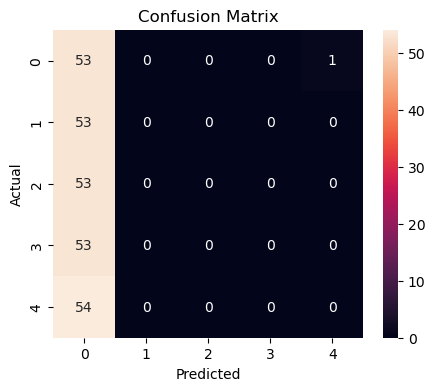

In [18]:
oner = DecisionTreeClassifier(max_depth=1, random_state=42)
oner.fit(X=X_train, y=y_train)
predictions = oner.predict(X_test)
show_results(predictions, y_test)

## DECISION TREE CLASSIFIER

Predictions
0    160
1     44
3     38
2     20
4      5
dtype: int64

Accuracy = 24.7191%

Classification Report
              precision    recall  f1-score   support

           0     0.7963    0.2687    0.4019       160
           1     0.1887    0.2273    0.2062        44
           2     0.0377    0.1000    0.0548        20
           3     0.1698    0.2368    0.1978        38
           4     0.0370    0.4000    0.0678         5

    accuracy                         0.2472       267
   macro avg     0.2459    0.2466    0.1857       267
weighted avg     0.5360    0.2472    0.3083       267



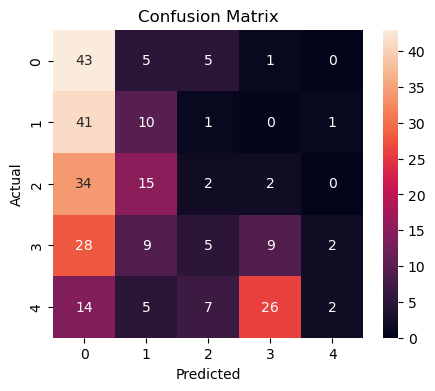

In [19]:
dt = DecisionTreeClassifier(max_depth=None, random_state=42)
dt.fit(X=X_train, y=y_train)
predictions = dt.predict(X_test)
show_results(predictions, y_test)

## NAIVE BAYES CLASSIFIER

Predictions
1    186
0     42
2     35
3      4
dtype: int64

Accuracy = 30.7116%

Classification Report
              precision    recall  f1-score   support

           0     0.5926    0.7619    0.6667        42
           1     0.7547    0.2151    0.3347       186
           2     0.1887    0.2857    0.2273        35
           3     0.0000    0.0000    0.0000         4
           4     0.0000    0.0000    0.0000         0

    accuracy                         0.3071       267
   macro avg     0.3072    0.2525    0.2457       267
weighted avg     0.6437    0.3071    0.3678       267



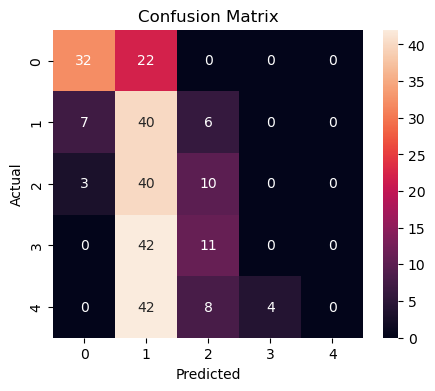

In [20]:
nb_classifier = GaussianNB()
nb_classifier.fit(X=X_train, y=y_train)
predictions = nb_classifier.predict(X_test)
show_results(predictions, y_test)

## SOURCE
https://www.kaggle.com/datasets/arnabchaki/laptop-price-prediction